<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

k = 1
l = 1

def exact_solution(x):
    return torch.sin(k * x[:, 0:1]) * torch.cos(l * x[:, 1:2])

def f(x, k=1):
    return (k**2+l**2) * torch.sin(k * x[:, 0:1]) * torch.cos(l * x[:, 1:2])

def g(x):
    return exact_solution(x).view(-1, 1)

def sample_domain(num_points):
    x = torch.linspace(0, np.pi, num_points, device=device)
    y = torch.linspace(0, np.pi, num_points, device=device)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')
    return torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

def sample_boundary(num_points):
    x0 = torch.linspace(0, np.pi, num_points, device=device)
    x1 = torch.zeros(num_points, device=device)
    return torch.stack([x0, x1], dim=1)

class PINN(nn.Module):
    def __init__(self, layer_sizes):
        super(PINN, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.Tanh())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def compute_loss(model, x_interior, x_boundary):
    x_interior.requires_grad_(True)

    u_interior = model(x_interior)

    grad_u = torch.autograd.grad(u_interior, x_interior,
                                 grad_outputs=torch.ones_like(u_interior),
                                 create_graph=True)[0]

    u_xx = torch.autograd.grad(grad_u[:, 0], x_interior,
                               grad_outputs=torch.ones_like(grad_u[:, 0]),
                               create_graph=True)[0][:, 0]

    u_yy = torch.autograd.grad(grad_u[:, 1], x_interior,
                               grad_outputs=torch.ones_like(grad_u[:, 1]),
                               create_graph=True)[0][:, 1]

    loss_pde = torch.mean((u_xx + u_yy + f(x_interior))**2)

    u_boundary = model(x_boundary)
    u_exact_boundary = g(x_boundary)

    loss_bc = torch.mean((u_boundary - u_exact_boundary)**2)

    return loss_pde + loss_bc

num_domain = 100
num_boundary = 1000
x_interior = sample_domain(num_domain)
x_boundary = sample_boundary(num_boundary)

layer_sizes = [2, 100, 100, 1]
model = PINN(layer_sizes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_interior, x_boundary)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 1.449671983718872
Epoch 1000, Loss: 0.9999104142189026
Epoch 2000, Loss: 0.9999034404754639
Epoch 3000, Loss: 0.9999023675918579
Epoch 4000, Loss: 0.999902069568634
Epoch 5000, Loss: 0.9999698400497437
Epoch 6000, Loss: 0.999901294708252
Epoch 7000, Loss: 0.9999012351036072
Epoch 8000, Loss: 0.9999499320983887
Epoch 9000, Loss: 0.9999005794525146


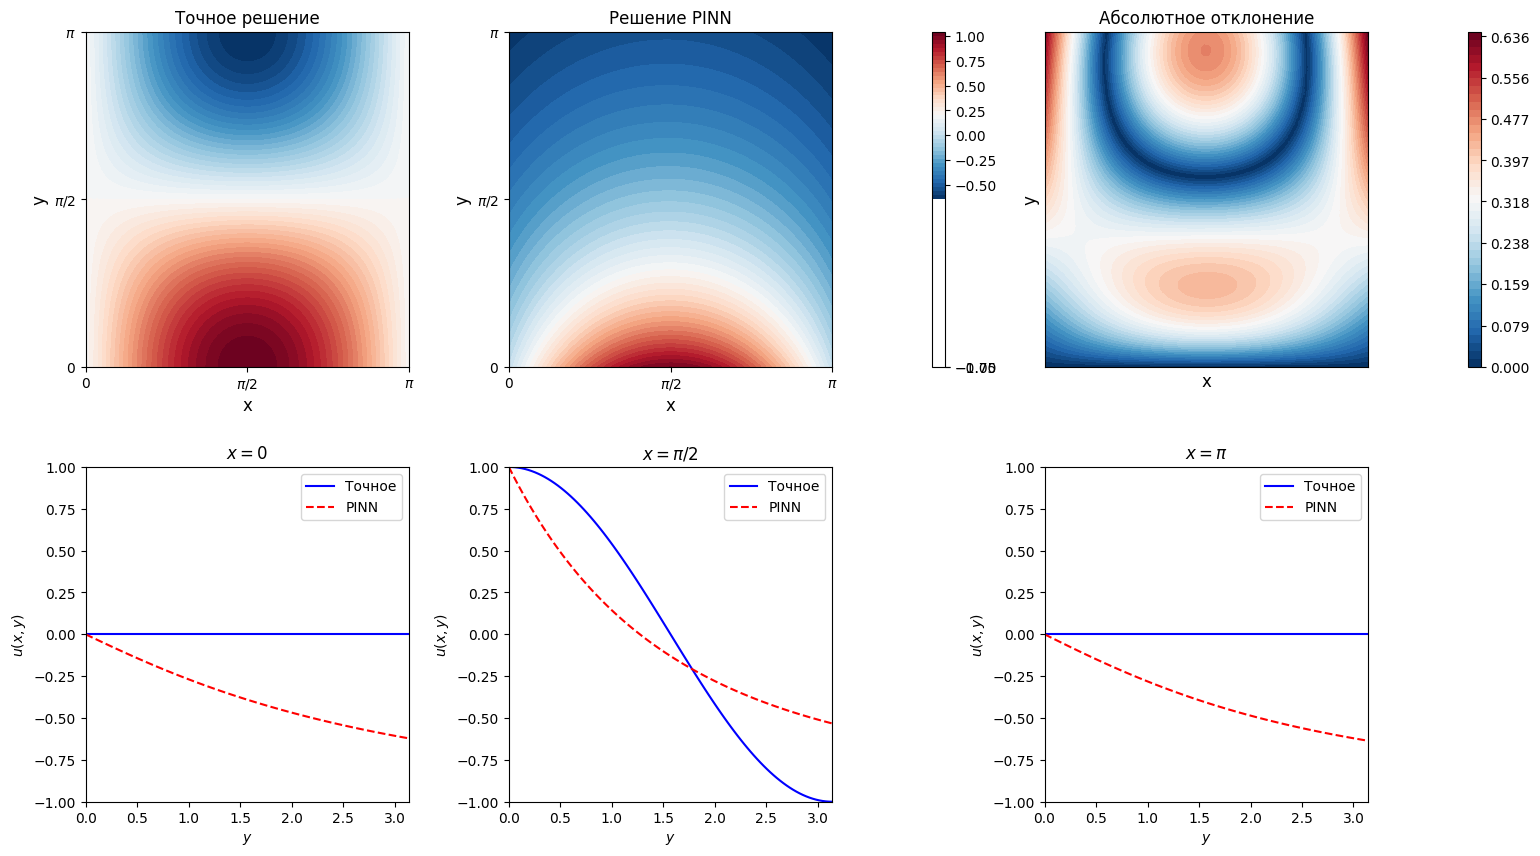

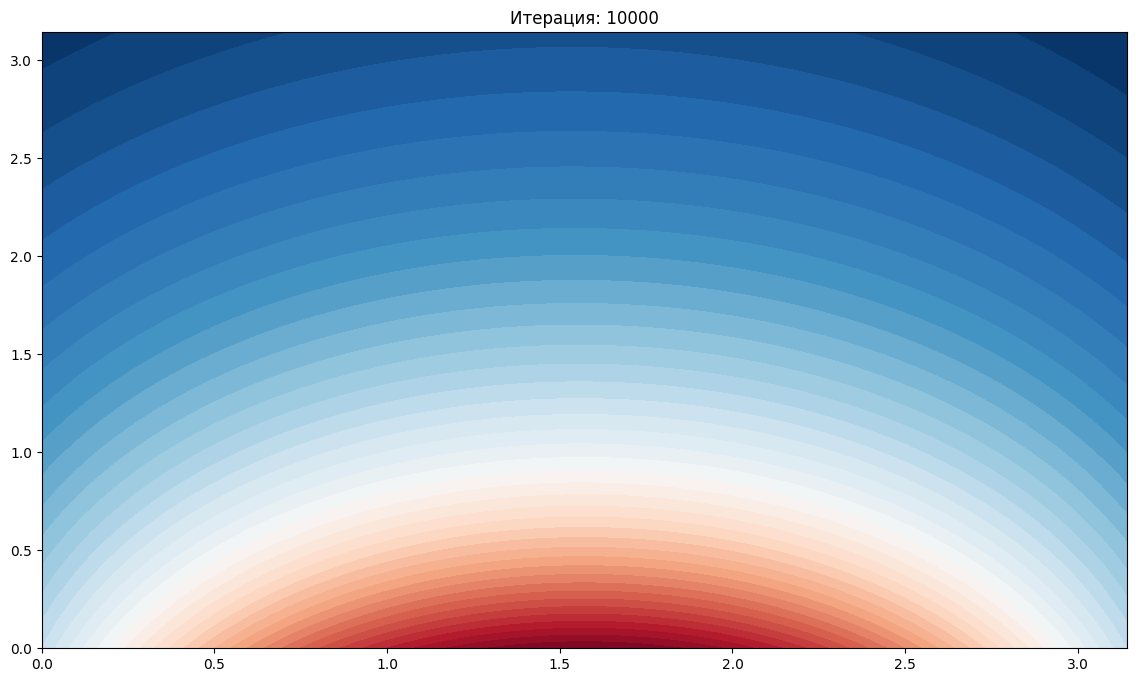

In [21]:
from matplotlib import colors
import matplotlib.gridspec as gridspec

def visualize_solution(model):
    x = sample_domain(100)
    x_cpu = x.cpu().numpy()
    x_tensor = x.clone().detach().to(dtype=torch.float32)
    y_exact = g(x_tensor).detach().cpu().numpy().flatten()

    model.eval()
    with torch.no_grad():
        y_pred = model(x_tensor).cpu().numpy().flatten()

   # plt.figure(figsize=(14, 8))

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [y_exact.reshape(100,100), y_pred.reshape(100,100), np.abs(y_exact - y_pred).reshape(100,100)]

    h_min, h_max, v_min, v_max = 0, np.pi, 0, np.pi

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1], width_ratios=[1, 1, 0.04, 1, 0.04], wspace=0.5, hspace=0.3)

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [y_exact, y_pred, np.abs(y_exact - y_pred)]

    def create_subplot(ax, data, title):
        c = plt.tricontourf(x_cpu[:, 0], x_cpu[:, 1], data, levels=50, cmap="RdBu_r")
        #c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])
        if title == "Абсолютное отклонение":
          ax.set_xticks([])
          ax.set_yticks([])
        return c

    c1 = create_subplot(fig.add_subplot(gs[0, 0]), data[0],titles[0])

    c4 = create_subplot(fig.add_subplot(gs[0, 3]), data[2],titles[2])

    c2 = create_subplot(fig.add_subplot(gs[0, 1]), data[1],titles[1])


    norm = colors.Normalize(vmin=-1, vmax=1)
    cbar = fig.colorbar(c2, cax=fig.add_subplot(gs[0, 2]), norm=norm)
    cbar.set_ticks(np.linspace(-1, 1, 9).round(2))

    def add_colorbar(c, ax, data):
      norm = plt.Normalize(np.min(data), np.max(data))
      cbar = fig.colorbar(c, cax=ax, norm=norm)
      cbar.set_ticks(np.linspace(np.min(data), np.max(data), 9).round(3))

    add_colorbar(c4, fig.add_subplot(gs[0, 4]), data[2])

    x_values = [0, np.pi/2, np.pi]
    y_slice = np.linspace(0, np.pi, 100)

    A = ['0', '\pi/2', '\pi']

    #plt.figure(figsize=(12, 4))

    device = next(model.parameters()).device  # Получаем устройство модели

    for i, t in enumerate(x_values):
        x_test = np.column_stack([np.full_like(y_slice, t), y_slice])
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  # Перемещаем на то же устройство, что и модель
        y_exact = exact_solution(x_test_tensor).detach().cpu().numpy().flatten()

        with torch.no_grad():
            y_pred = model(x_test_tensor).cpu().numpy().flatten()

        if i == 2:
            c_ax = fig.add_subplot(gs[1, i+1])
        else:
            c_ax = fig.add_subplot(gs[1, i])

        c_ax.plot(y_slice, y_exact, 'b-', label="Точное")
        c_ax.plot(y_slice, y_pred, 'r--', label="PINN")
        c_ax.set_xlabel(r"$y$")
        c_ax.set_ylabel(r"$u(x, y)$")
        c_ax.set_title(f'$x = {A[i]}$')
        c_ax.set_xlim(0, np.pi)
        c_ax.set_ylim(-1, 1)
        c_ax.legend()

    plt.show()

def animate_solution(model, num_frames=10):
    fig, ax = plt.subplots(figsize=(14, 8))
    x = sample_domain(100)
    x_cpu = x.cpu().numpy()
    x_tensor = x.clone().detach().to(dtype=torch.float32)

    predictions = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_frames):
            predictions.append(model(x_tensor).cpu().numpy().flatten())

    def update(frame):
        ax.clear()
        ax.tricontourf(x_cpu[:, 0], x_cpu[:, 1], predictions[frame], levels=50, cmap="RdBu_r")
        ax.set_title(f"Итерация: {num_frames * 1000}")

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), repeat=False)
    ani.save('solution_animation.mp4', writer='ffmpeg', fps=2)

visualize_solution(model)

animate_solution(model)
